# Example of generation of valid data mask using a predicate

Notebook showing an example of predicate for generation of valid data mask 

In [1]:
from eolearn.core.eoworkflow import EOWorkflow, Dependency
from eolearn.core.eodata import FeatureType

In [2]:
from sentinelhub import BBox, CRS

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [4]:
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask

Define ROI BBOX and time interval

In [5]:
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2017-04-01', '2017-05-31')

### Workflow to merge the cloud mask with the mask defining where reflectance data is available

The predicate merges the cloud mask with the `IS_DATA` mask which defines where reflectance data is available. For orbits covering partially the ROI, the `IS_DATA` mask values will be 0.

In [6]:
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [7]:
layer = 'BANDS-S2-L1C'

input_task = S2L1CWCSInput(layer=layer, 
                           resx='20m', resy='20m', 
                           maxcc=1, time_difference=datetime.timedelta(hours=2))

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 
                           'BANDS-S2-L1C', 
                           cm_size_y='60m', 
                           cm_size_x='60m', 
                           cmask_feature='CLM',
                           cprobs_feature='CLP')

add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Run workflow

In [8]:
workflow = EOWorkflow.make_linear_workflow(input_task,add_clm, add_valmask)
result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connec

Plot results

In [9]:
eopatch = [result[key] for key in result.keys()][0]
eopatch.get_features()

{<FeatureType.BBOX: 'bbox'>: True,
 <FeatureType.DATA: 'data'>: {'BANDS-S2-L1C', 'CLP'},
 <FeatureType.MASK: 'mask'>: {'CLM', 'IS_DATA', 'VALID_DATA'},
 <FeatureType.META_INFO: 'meta_info'>: {'maxcc',
  'service_type',
  'size_x',
  'size_y',
  'time_difference',
  'time_interval'},
 <FeatureType.TIMESTAMP: 'timestamp'>: True}

Display the input masks (`IS_DATA` mask on the left and cloud mask `CLM` in the middle) and the resulting merged mask (`VALID_DATA` on the right)

Text(0.5,1,'VALID_DATA')

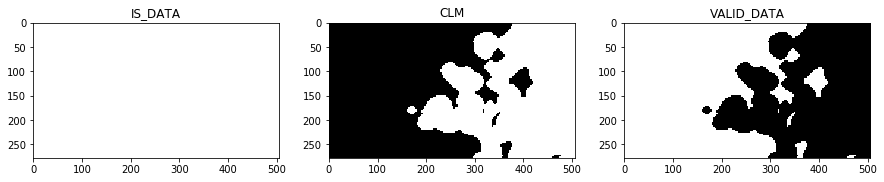

In [10]:
tidx = 5
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(eopatch.mask['IS_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.title('IS_DATA')
plt.subplot(132)
plt.imshow(eopatch.mask['CLM'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.title('CLM')
plt.subplot(133)
plt.imshow(eopatch.mask['VALID_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.title('VALID_DATA')